<a href="https://colab.research.google.com/github/ol3gka/AI_Masters_NLA_projects_Matrix_Masters/blob/main/Project_2/project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Сравнение скоростей работы, потребления памяти, точности аппроксимации в зависимости от ранга CP, Такер, ТТ

Олег Николаев

In [2]:
pip install tntorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 524.5 kB/s eta 0:00:00


In [4]:
import torch
torch.set_default_dtype(torch.float64)
import tntorch as tn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

In [10]:
SHAPE_CONST = 128 # исследуем алгоритмы на равносторонних тензорах

# инициализируем матрицы
X, Y, Z = np.meshgrid(range(SHAPE_CONST), range(SHAPE_CONST), range(SHAPE_CONST))
full = torch.Tensor(1. / (X + Y + Z + 1))  # аналитическая связь индесов

# алгоритм для тестирования алгоритмов

rank_range = np.arange(1, 50, 5)

approximation_error = {}
time_dict = {}
memory_consumption = {}
algorithms = ["Каноническое разложение (CP)", "Разложение Таккера", "Тензорный поезд (TT)"]

for algo in tqdm(algorithms):
  error_array = []
  ranks_cp, ranks_tucker, ranks_tt = None, None, None
  for r in rank_range:
    if algo == "Каноническое разложение (CP)":
      ranks_cp = r
    elif algo == "Разложение Таккера":
      ranks_tucker = r
    elif algo == "Тензорный поезд (TT)":
      ranks_tt = r
    t  = tn.Tensor(full, ranks_cp=ranks_cp, ranks_tucker=ranks_tucker, ranks_tt=ranks_tt, verbose=False, tol=1e-5, max_iter=50)
    error_array.append(torch.norm(t.torch() - full).item() / torch.norm(full).item())

  approximation_error[algo] = error_array



100%|██████████| 3/3 [00:20<00:00,  6.87s/it]


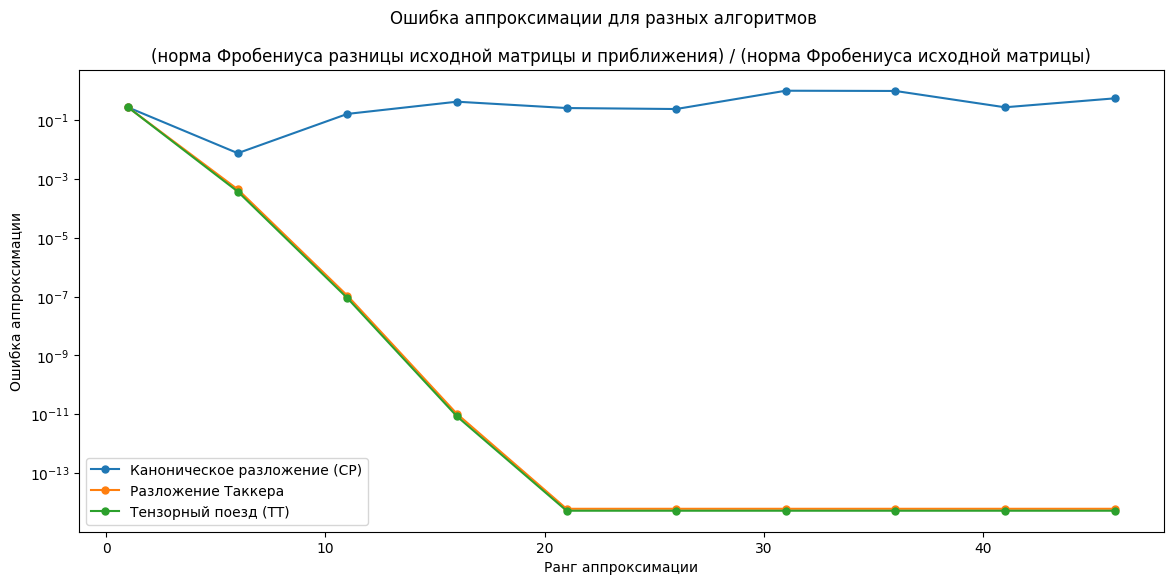

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
for algo, error in approximation_error.items():
  ax.plot(rank_range, error, label=algo, marker='o', markersize=5, linestyle='-')
ax.set_yscale('log')
fig.suptitle("Ошибка аппроксимации для разных алгоритмов")
ax.set_title("(норма Фробениуса разницы исходной матрицы и приближения) / (норма Фробениуса исходной матрицы)")
plt.xlabel("Ранг аппроксимации")
plt.ylabel("Ошибка аппроксимации")
plt.legend()
plt.show()

Text(0, 0.5, 'Rel approximation error')

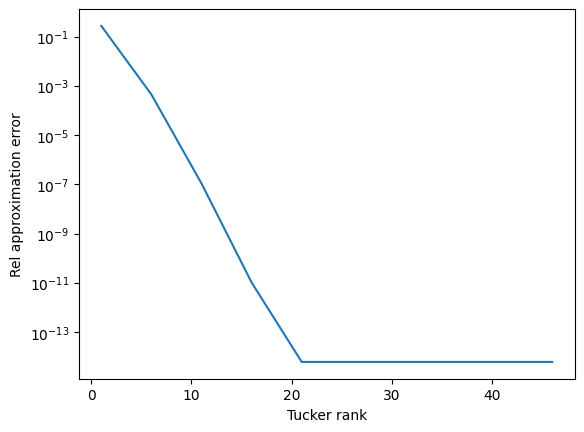

In [6]:
t_error = []
for t_rank in rank_range:
    tt_tucker_t = tn.Tensor(full, ranks_tucker=t_rank)
    t_error.append(torch.norm(tt_tucker_t.torch() - full).item() / torch.norm(full).item())

plt.semilogy(rank_range, t_error)
plt.xlabel("Tucker rank")
plt.ylabel("Rel approximation error")

Text(0, 0.5, 'Rel approximation error')

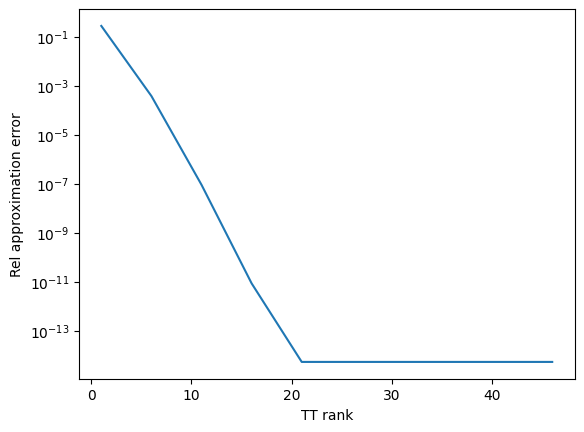

In [7]:
error_rec = []
for r in rank_range:
    tt_t = tn.Tensor(full, ranks_tt=r)
    error_rec.append(torch.norm(tt_t.torch() - full).item() / torch.norm(full).item())
plt.semilogy(rank_range, error_rec)
plt.xlabel("TT rank")
plt.ylabel("Rel approximation error")

In [8]:
print(cp_t)
print(tt_t)
print(tt_tucker_t)
print(cp_t.numcoef(), tt_t.numcoef(), tt_tucker_t.numcoef(), full.numel())

3D CP tensor:

 128 128 128
  |   |   |
 <0> <1> <2>
 / \ / \ / \
46  46  46  46

3D TT tensor:

 128 128 128
  |   |   |
 (0) (1) (2)
 / \ / \ / \
1   20  20  1

3D TT-Tucker tensor:

 128 128 128
  |   |   |
 20  20  20
 (0) (1) (2)
 / \ / \ / \
1   128 20  1

17664 56320 61840 2097152


# **Тензорный поезд**

Как достижения мультилинейной алгебры помогают преодолеть проклятие размерности?

<div>
<img src="https://raw.githubusercontent.com/ol3gka/AI_Masters_NLA_projects_Matrix_Masters/main/pictures/TT1.png" width="600"/>
</div>

 Источник: iclcollective.com

In [ ]:
https://habr.com/ru/companies/airi/articles/747626/

https://github.com/G-Ryzhakov/Constructive-TT/blob/main/cooperative_games.ipynb